In [1]:
from cereeberus import ReebGraph, MapperGraph, Interleave
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Using PuLP to solve the ILP (Should I use something else?)
import pulp

# Given two mapper graphs and all the associated matrices, I am trying to see if the problem can be solved using integer linear programming (ILP).

_Note to self: Fill in the ILP details here._

## Let's create two example mapper graphs.

Text(0.5, 1.0, 'T')

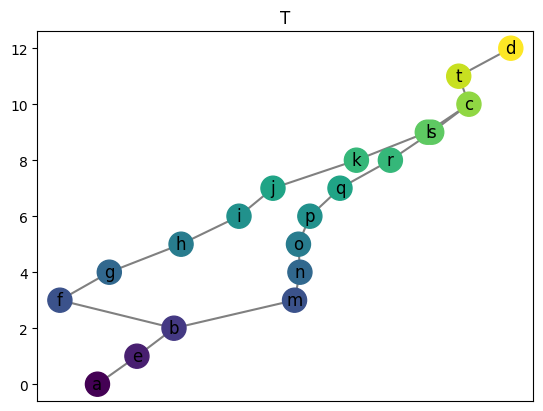

In [3]:
T = ex_mg.torus(0, 2, 10, 12, delta = 1, seed = 17)
T.draw()
plt.title('T')

Text(0.5, 1.0, 'L')

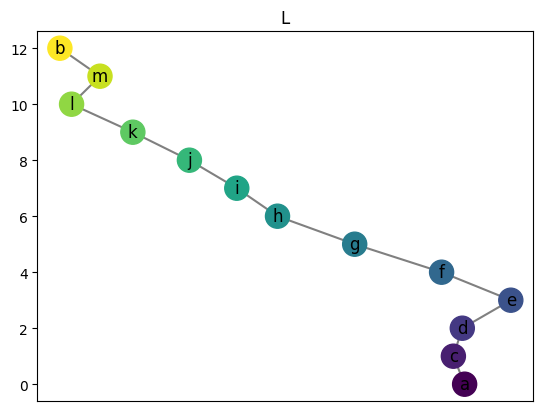

In [4]:
L = ex_mg.line(0, 12)
L.draw()
plt.title('L')

Create an interleaving and to generate all the relevant matrices.

Then, we can try to solve the problem using ILP.

In [5]:
myInt = Interleave(T, L, initialize_random_maps=True, seed=0)

## Let's get all the matrices. Diagram: Vertex triangle F_G_F.

Inclusion matrices to define the maps $F \to F_n \to F_{2n}$ and $G \to G_n \to G_{2n}$. Can be accessed by `Interleave.I`. 

For vertex triangle from $F$ to $G$, we need $I^V_{F^n}$ and $I^V_{F}$

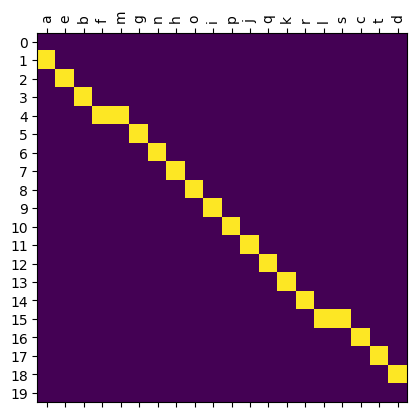

In [6]:
# Inclusion matrices 

I_F_0 = myInt.I('F', '0', 'V')
I_F_0.draw()

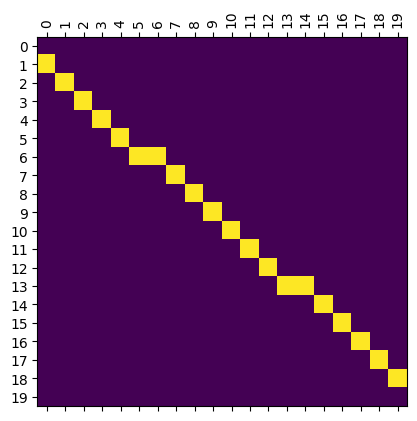

In [7]:
I_F_n = myInt.I('F', 'n', 'V')
I_F_n.draw()

Multiply $I^V_{F^n}$ with $I^V_{F}$ and denote it by $I$. <span style="color:red"> Is the multiplication method  correct? </span>

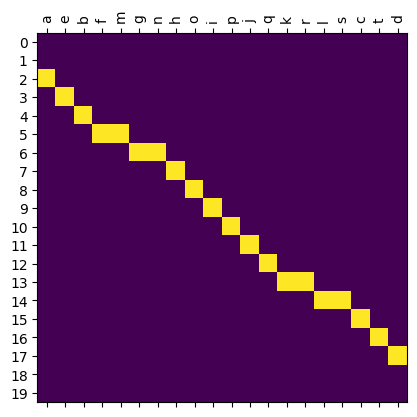

In [8]:
# multiply two matrices
I = I_F_n @ I_F_0
I.draw()

# We also keep a labeled matrix representation of the inclusion matrix
I_mat = I.to_labeled_matrix().get_array()

Store the distance matrix too. We need $D^V_{F^{2n}}$. Can be summoned by `Interleave.D`.

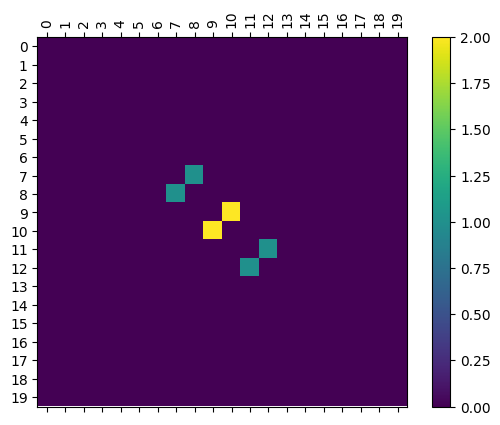

In [9]:
D = myInt.D('F', '2n', 'V')
D.draw(colorbar=True)

# We also keep a labeled matrix representation of the distance matrix
D_mat = D.to_labeled_matrix().get_array()


Let's also store a $\varphi_V$ and $\psi_V^n$ matrices. These two are variable matrices in the ILP. Can be summoned by `Interleave.phi` and `Interleave.psi`.

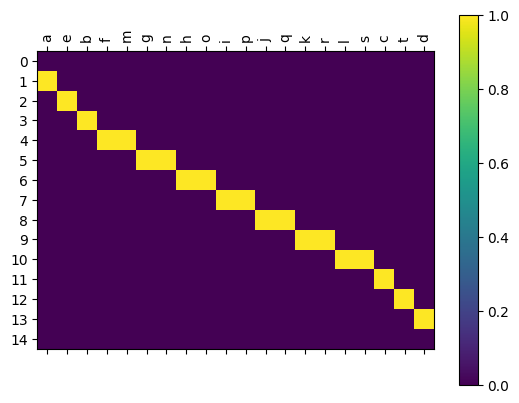

In [10]:
phi = myInt.phi('0', 'V')
phi.draw(colorbar=True)

# We also keep a labeled matrix representation of the phi matrix
phi_mat = phi.to_labeled_matrix().get_array()


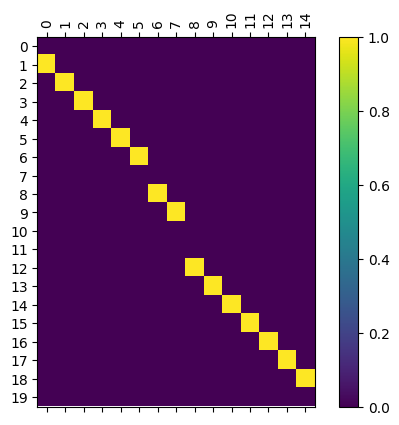

In [11]:
psi_n = myInt.psi('n', 'V')
psi_n.draw(colorbar=True)

# We also keep a labeled matrix representation of the psi matrix
psi_n_mat = psi_n.to_labeled_matrix().get_array()

### Before we set an ILP, let's check the dimension and function values of the matrices. Also, if everything lines up, we will try to solve it by block level.

In [12]:
# Print shapes of the matrices
print(f"Shape of inclusion matrix product I_F_n @ I_F_0: {I.shape()}")
print(f"Shape of distance matrix D: {D.shape()}")
print(f"Shape of phi matrix: {phi.shape()}")
print(f"Shape of psi matrix: {psi_n.shape()}")

Shape of inclusion matrix product I_F_n @ I_F_0: (20, 20)
Shape of distance matrix D: (20, 20)
Shape of phi matrix: (15, 20)
Shape of psi matrix: (20, 15)


In [13]:
# print the function values (block indices) of the matrices
print(f"Function values of inclusion matrix product I_F_n @ I_F_0: {I.get_all_block_indices()}")
print(f"Function values of distance matrix D: {D.get_all_block_indices()}")
print(f"Function values of phi matrix: {phi.get_all_block_indices()}")
print(f"Function values of psi matrix: {psi_n.get_all_block_indices()}")

Function values of inclusion matrix product I_F_n @ I_F_0: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Function values of distance matrix D: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Function values of phi matrix: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Function values of psi matrix: [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


## Attempt to set up the ILP.

### Initialize the ILP


In [14]:
prob = pulp.LpProblem("Triangle_ILP", pulp.LpMinimize)

### Matrix Parameters

In [15]:
I = I_mat # Inclusion matrix
D = D_mat # Distance matrix
phi = phi_mat # Phi matrix
psi = psi_n_mat # Psi matrix

In [16]:
print(type(I_mat))

<class 'numpy.ndarray'>


<span style="color:red"> There should be a way to extract the dimensions from the matrices. Right now, I am hardcoding the dimensions. </span>

### Let's clear up the dimension problem


In [17]:
m = 20 # Number of rows in $\psi_n$
n = 15 # Number of columns in $\phi_n$ or Numbe of rows in $\phi$
p = 20 # Number of columns in $\phi$


### define the decision variables


In [18]:
z = pulp.LpVariable.dicts("z", ((i, j, k) for i in range(m) for j in range(n) for k in range(p)), cat='Binary')
psi_vars = pulp.LpVariable.dicts("psi", ((i, j) for i in range(m) for j in range(n)), lowBound=0, cat='Continuous')
phi_vars = pulp.LpVariable.dicts("phi", ((j, k) for j in range(n) for k in range(p)), lowBound=0, cat='Continuous')
psi_phi = pulp.LpVariable.dicts("psi_phi", ((i, k) for i in range(m) for k in range(p)), lowBound=0, cat='Continuous')
minmax_var = pulp.LpVariable("m", lowBound=0, cat='Continuous')

### Objective function

In [19]:
prob += minmax_var

### Constraints
1. $m \geq  \sum_{i=1}^{m} d_{ij}(I_{ik}-C_{ik})$ for each $j$ and $k$.
2. $-m \leq  \sum_{i=1}^{m} d_{ij}(I_{ik}-C_{ik})$ for each $j$ and $k$. 


In [20]:
for i in range(m):
    prob += minmax_var >= pulp.lpSum(D[i][k] *(I[i][k] - psi_phi[i,k])  for k in range(p))
    prob += -minmax_var <= pulp.lpSum(D[i][k] *(I[i][k] - psi_phi[i,k]) for k in range(p))

### Constraints

$C_{ik} = \sum_{j=1}^{n} z_{ijk}$ for each $i$ and $k$.

In [21]:
for i in range(m):
    for k in range(p):
        prob += psi_phi[i,k] == pulp.lpSum(z[i, j, k] for j in range(n))


### Constraints

1. $z_{ijk} \leq \psi_{ij}$ for each $i$, $j$ and $k$.
2. $z_{ijk} \leq \phi_{jk}$ for each $i$, $j$ and $k$

In [22]:
for i in range(m):
    for j in range(n):
        for k in range(p):
            prob += z[i, j, k] <= psi[i, j] 
            prob += z[i, j, k] <= phi[j, k]

### Constraints

$z_{ijk} \geq \psi_{ij} + \phi_{jk} - 1$ for each $i$, $j$ and $k$.

In [23]:
print(type(psi))

<class 'numpy.ndarray'>


In [24]:
for i in range(m):
    for j in range(n):
        for k in range(p):
            prob += z[i, j, k] >= psi[i, j] + phi[j, k] - 1

### Constraints

1. $ \sum_{i=1}^{m} \psi_{ij} \leq 1$ for each $j$.
2. $ \sum_{j=1}^{m} \varphi{jk} \leq 1$ for each $k$.

In [25]:
for i in range(m):
    prob += pulp.lpSum(psi_vars[i,j] for j in range(n)) <= 1   

for j in range(n):
    prob += pulp.lpSum(phi_vars[j,k] for k in range(p)) <= 1

### Constraints

1. $ \psi_{ij} \geq 0$ for each $i$ and $j$.
2. $ \varphi_{jk} \geq 0$ for each $j$ and $k$.

In [26]:
for i in range(m):
    for j in range(n):
        prob += psi_vars[i,j] >= 0

for j in range(n):
    for k in range(p):
        prob += phi_vars[j,k] >= 0

## Solve the ILP

In [27]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ishikaghosh/anaconda3/envs/interleavingenv/lib/python3.13/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/5f/m89pr_zs78n8ffl7t7ndknth0000gn/T/0ab7a863c6c5499fa7242a8a8fdfed0c-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/5f/m89pr_zs78n8ffl7t7ndknth0000gn/T/0ab7a863c6c5499fa7242a8a8fdfed0c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 19080 COLUMNS
At line 56734 RHS
At line 75810 BOUNDS
At line 81811 ENDATA
Problem MODEL has 19075 rows, 7001 columns and 25652 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2 - 0.01 seconds
Cgl0002I 5980 variables fixed
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 2 to -1.797

1

## Output the solution

In [28]:
print(f"Objective value (minimization over the maximum of the absolute values of the matrix) = {pulp.value(prob.objective)}")

Objective value (minimization over the maximum of the absolute values of the matrix) = 2.0
